# Semi-Supervised Learning

**Goal:** Is to develop a Pseudo-labeling approach to label tweets as hate or non-hate which is a Semi-Supervised Learning classification task.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import pickle
import os
import json
import datetime
import contractions
import pickle
import mysql.connector
from mysql.connector import Error
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
import joblib
import statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import auc, average_precision_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from string import punctuation
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
plt.rcParams['figure.figsize'] = (18, 5)
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
import sys
# Path to the module (ModelInference) and config
sys.path.append('/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src')
from pipeline.modelinference import ModelInference
from config import config

/home/daniel/.local/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/home/daniel/.local/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
class ToPandasDF():
    def __init__(self, password, host, database, user):

        self.password = password
        self.host = host
        self.database = database
        self.user = user
        
    
    def MySQLconnect(self, query):
        
        try:
            connection = mysql.connector.connect(host=self.host, 
                                                 database=self.database, 
                                                 password=self.password,
                                                 user=self.user)

            if connection.is_connected():

                print("Successfully connected to the database\n")

                cursor = connection.cursor()
                query = query
                cursor.execute(query)

                data = cursor.fetchall()

                df = pd.DataFrame(data, columns = ['id', 'date', 'tweet'])
        except Error as e:
            print(e)
            
        cursor.close()
        connection.close()
        
        return df
    
    def check_if_valid_data(self, data):
        
        # Create a timestamp of the date(Day, Month & Year)
        data['timestamp'] = data['date'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))
        
        if data.empty:
            print("No tweets downloaded. Finishing execution")
            
        if data['id'].unique().all():
            pass
        else:
            print(f"Primary Key check is violated, Number of duplicate values: {data.duplicated().sum()}")
            
        if data.isnull().values.any():
            print(f"\nNull values detected, Number of null: \n{data.isnull().sum()}")
        
        yesterday = datetime.datetime.now() - datetime.timedelta(days=1)
        yesterday = yesterday.replace(hour=0, minute=0, second=0, microsecond=0)
        timestamps = data['timestamp'].tolist()
        for timestamp in timestamps:
            if datetime.datetime.strptime(timestamp, '%Y-%m-%d') != yesterday:
                print("Atleast one of the returned tweet does not come from within the last 24 hours")
        
    def basic_processing(self, data):
        data = data.drop(['date', 'timestamp'], axis=1)
        print(f'\nNumber of duplicate entry of unlabelled data: {data.tweet.duplicated().sum()}')
        # Remove duplicates
        data = data[~data.tweet.duplicated()]
        print(f'Duplicate entry removed: {data.tweet.duplicated().sum()}')
        # We will remove the usernames and RT(retweet) in the tweet column
        # data['tweet'] = data.tweet.replace(regex=re.compile(r"@([A-Za-z0-9_]+)"), value='')
        # data['tweet'] = data.tweet.replace(regex=re.compile(r"RT([\s:]+)"), value='')
        return data

    def load_train_data(self):
        data = pd.read_csv(os.path.join(config.DATAPATH, 'train.csv'))
        # Remove all records with no label
        data = data[data.label != '']
        # data['tweet'] = data.tweet.replace(regex=re.compile(r"@([A-Za-z0-9_]+)"), value='')
        return data

if __name__ == '__main__':
    
    t = ToPandasDF(config.PASSWORD, config.HOST, config.DATABASE, config.USER)
    stored_data = t.MySQLconnect("SELECT id, created_at, tweet FROM `twitterdb`.`twitter_table`;")
    t.check_if_valid_data(stored_data)
    unlabelled_data = t.basic_processing(stored_data)
    labelled_data = t.load_train_data()

Successfully connected to the database

Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the retur

In [3]:
print(unlabelled_data.shape)
unlabelled_data.info()
unlabelled_data.head(10)

(3112, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3112 entries, 0 to 4022
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3112 non-null   object
 1   tweet   3112 non-null   object
dtypes: object(2)
memory usage: 72.9+ KB


,id,tweet
0,1547971096388915211,Truth and Reconciliation Week - sign up VSB ed...
1,1547973807876345856,Uh oh she’s writing songs #inthefeels 🔪
2,1548039239316541449,#Killing white #supremacists by Bill O'Really....
3,1548287847995609092,hiya. cats are feeling fuming and accomplished...
4,1548297674062868480,If home ownership requires generational wealth...
5,1548327299304783875,RT @RobertR41182121: THIS IS SATANIC #ZIONAZI ...
6,1548582052240539648,@Inspiredlawyer #BabyFactories: sick ultimate ...
7,1548640420418273282,#Platform class kotlin.Unit #requires explicit...
8,1548681295189901317,The Let Them Eat Cake Club #Supremacists #Liar...
10,1549225465658982401,Kinda sad my bachelorette party is over 🥺#miss...


In [4]:
# Initialize the TfidfVectorizer, Lemmatizer and stopwords
# tfVectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, max_features=800, ngram_range=(1, 1), use_idf=True)tfVectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, max_features=800, ngram_range=(1, 1), use_idf=True)
tfVectorizer = TfidfVectorizer(min_df=5, max_df=0.75, max_features=1000, ngram_range=(1, 2))
lemmatizer = WordNetLemmatizer()
stopwords = set(json.load(open("/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/stopWords/custome_nltk_stopwords.json", "r")))
stopwords_json = set(json.load(open("/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/stopWords/custome_json_stopwords.json", "r")))
stopwords_punctuation = set.union(stopwords, stopwords_json, punctuation)

print(labelled_data.shape)
labelled_data.info()
labelled_data.head(10)

(31962, 3)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 998.8+ KB


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


# Target Exploration (label)

In [5]:
labelled_data.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

**The dataset is imbalanced based on hate speech**

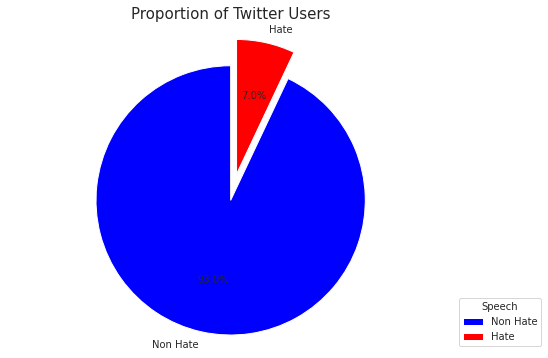

In [6]:
size=labelled_data.label.value_counts()
labels='Non Hate', 'Hate'
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(size, explode=(0, 0.2), labels=labels, autopct='%1.1f%%', startangle=90, colors=['blue', 'red'])
ax.axis('equal')
plt.title('Proportion of Twitter Users', size=15)
ax.legend(labels, bbox_to_anchor=(1, 0), loc='lower left', title='Speech')
plt.show()

It is given that 7.0% of twitter users might Hate. So the baseline model could be to predict that 7.0% of the users will Hate. Given 7.0% is a small number, we need to ensure that the chosen model does predict with great accuracy this 7.0% as it is of interest to the company to identify these users as opposed to accurately predicting the users that are non haters.

In [7]:
def basic_prep(data):
    data['mention_count'] = data.tweet.apply(lambda x: len(re.findall(r"@[\w\-]+", x)))
    data['tweet'] = data.tweet.replace(regex=re.compile(r"@([A-Za-z0-9_]+)"), value='')
    data['tweet'] = data.tweet.replace(regex=re.compile(r"RT([\s:]+)"), value='')
    return data

def preprocess_text(text):
    
    """Function to clean text from irrelevant words and symbols"""
    
    if type(text) == float:
        print('Entry not valid')
        return ""
    sentence = []
    
    # Tokenize and lowercase all alphabet
    tokens = [contractions.fix(i.lower()) for i in word_tokenize(str(text))]
    
    # Part of speech
    tags = pos_tag(tokens)
    
    for (token, tag) in tags:
        # Remove all irrelevant symbols from token
        token = re.sub(r"([0-9]+|[-_@./&+]+|``)", '', token)
        token = re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|#|http\S+", '', token)
        token = token.encode("ascii", "ignore")
        token = token.decode()
        
        # Grab the positions of the nouns(NN), verbs(VB), adverb(RB), and adjective(JJ)
        if tag.startswith('NN'):
            position = 'n'
        elif tag.startswith('VB'):
            position = 'v'
        elif tag.startswith('RB'):
            position = 'r'
        else:
            position = 'a'

        lemmatized_word = lemmatizer.lemmatize(token, position)
        if lemmatized_word not in stopwords_punctuation:
            sentence.append(lemmatized_word)
    final_sent = ' '.join(sentence)
    final_sent = final_sent.replace("n't", 'not').replace("nt", "not")
    return final_sent

data_cleaned = labelled_data.copy()
data_cleaned = basic_prep(data_cleaned)
data_cleaned['cleaned_text'] = data_cleaned.tweet.apply(preprocess_text)
print(f'The longest for labelled tweet is: {max(data_cleaned.cleaned_text.str.len())}')
print(f'The shortest for labelled tweet is: {min(data_cleaned.cleaned_text.str.len())}')

unlabelled_cleaned = unlabelled_data.copy()
unlabelled_cleaned = basic_prep(unlabelled_cleaned)
unlabelled_cleaned['cleaned_text'] = unlabelled_cleaned.tweet.apply(preprocess_text)
print(f'The longest for unlabelled tweet is: {max(unlabelled_cleaned.cleaned_text.str.len())}')
print(f'The shortest for unlabelled tweet is: {min(unlabelled_cleaned.cleaned_text.str.len())}')


The longest for labelled tweet is: 196
The shortest for labelled tweet is: 0
The longest for unlabelled tweet is: 297
The shortest for unlabelled tweet is: 0


# Visualize Word frequency

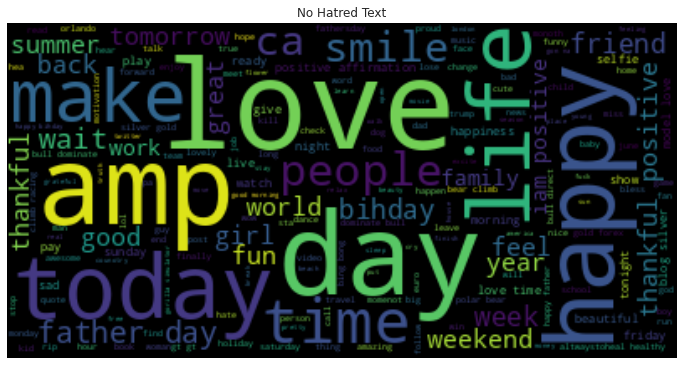

In [8]:
# Let's split the dataset into non hate(0) and hate(1) so as to visualize the frequency of the words
no_hate = data_cleaned[data_cleaned['label']==0]
hate = data_cleaned[data_cleaned['label']==1]

wordcloud = WordCloud(background_color='black').generate(' '.join(no_hate.cleaned_text))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('No Hatred Text')
plt.axis('off')
plt.show()

**Above, we can see that those are `non-hate` related words**

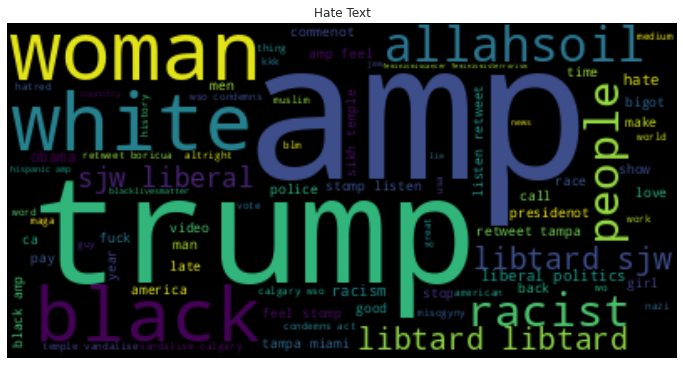

In [9]:
wordcloud = WordCloud(background_color='black').generate(' '.join(hate.cleaned_text))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Hate Text')
plt.axis('off')
plt.show()

In [10]:
def transform(data, column):
    # We will encode text data using TF-IDF
    tfidf_feats = tfVectorizer.fit(data[column])
    tfidf_feat_arr = tfidf_feats.transform(data[column]).toarray()
    tfidf = pd.DataFrame(tfidf_feat_arr, columns=tfVectorizer.get_feature_names())
    return tfidf, tfidf_feats

def merge(tfidf, data_to_merge):
    # Join both DataFrames
    data = tfidf.merge(data_to_merge, left_index=True, right_index=True)
    data = data.drop(['cleaned_text'], axis=1)
    return data

data_tfidf, tfVectorized = transform(data_cleaned, 'cleaned_text')
unlabelled_tfidf, _ = transform(unlabelled_cleaned, 'cleaned_text')

# Feature Engineering

## Frequency distribution of Part of Speech Tags

In [11]:
%%time 
pos_group = {
    'noun':['NN','NNS','NNP','NNPS'],
    'pron':['PRP','PRP$','WP','WP$'],
    'verb':['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj':['JJ','JJR','JJS'],
    'adv':['RB','RBR','RBS','WRB']
}

        
def count_pos_tag(text, flags):
    
    """Function to check and count the respective parts of speech tags"""
    
    count=0
    tokens = [contractions.fix(i.lower()) for i in word_tokenize(text)]
    tags = pos_tag(tokens)

    for (token, tag) in tags:
        token = re.sub(r"([0-9]+|[-_@./&+]+|``)", '', token)
        token = re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|#|http\S+", '', token)
        token = token.encode("ascii", "ignore")
        token = token.decode()
        if tag in pos_group[flags]:
            count+=1
    return count

def make_features(data):

    data['noun_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'noun'))
    data['verb_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'verb'))
    data['adj_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'adj'))
    data['adv_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'adv'))
    data['pron_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'pron'))

    data['char_count'] = data.tweet.apply(len)
    data['word_count'] = data.tweet.apply(lambda x: len(x.split()))
    data['uniq_word_count'] = data.tweet.apply(lambda x: len(set(x.split())))
    data['htag_count'] = data.tweet.apply(lambda x: len(re.findall(r'#[\w\-]+', x)))
    data['stopword_count'] = data.tweet.apply(lambda x: len([wrd for wrd in word_tokenize(x) if wrd in stopwords]))
    data['sent_count'] = data.tweet.apply(lambda x: len(sent_tokenize(x)))
    data['avg_word_len'] = data['char_count']/(data['word_count']+1)
    data['avg_sent_len'] = data['word_count']/(data['sent_count']+1)
    data['uniq_vs_words'] = data.uniq_word_count/(data.word_count+1) # Ratio of unique words to the total number of words
    data['stopwords_vs_words'] = data.stopword_count/(data.word_count+1)
    data['title_word_count'] = data.tweet.apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
    data['uppercase_count'] = data.tweet.apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
    data = data.drop(['tweet'], axis=1)
    return data




data_cleaned = make_features(data_cleaned)
unlabelled_cleaned = make_features(unlabelled_cleaned)

data_cleaned = merge(data_tfidf, data_cleaned)
unlabelled_cleaned = merge(unlabelled_tfidf, unlabelled_cleaned)

CPU times: user 3min 30s, sys: 1.8 s, total: 3min 32s
Wall time: 3min 32s


# Check for Missing Values

In [12]:
print(data_cleaned.isnull().sum().sort_values(ascending=False))

absolutely         0
pray               0
polar bear         0
police             0
political          0
                  ..
fun dog            0
funny              0
future             0
game               0
uppercase_count    0
Length: 1020, dtype: int64


In [13]:
print(unlabelled_cleaned.isnull().sum().sort_values(ascending=False))

ab                   0
public               0
problem              0
producer             0
product              0
                    ..
free                 0
freedom              0
freedom movemenot    0
french               0
uppercase_count      0
Length: 1019, dtype: int64


In [14]:
target_labelled_data = data_cleaned.label
data_cleaned = data_cleaned.drop(['id', 'label'], axis=1)
unlabelled_cleaned = unlabelled_cleaned.drop('id', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data_cleaned, target_labelled_data, test_size=0.2, random_state=43)
print(f"Train Size: {(X_train.shape[0]/data_cleaned.shape[0]):.2f}%")
print(f"Test Size: {(X_test.shape[0]/data_cleaned.shape[0]):.2f}%")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, unlabelled_cleaned.shape)

def confusion_matrix_plot(cm, normalized= True, cmap= 'bone'):
    norm_cm = cm
    if normalized:
        plt.figure(figsize=(6,4))
        norm_cm = (cm.astype('float')/ cm.sum(axis= 1)[:, np.newaxis])
        return sns.heatmap(norm_cm, annot= cm, fmt='g', 
                           xticklabels= ['Predicted: No Hate', 'Predicted: Yes Hate'], yticklabels=['Actual: No Hate', 'Actual: Yes Hate'])

def roc_auc_curve(y_test, pred):
    plt.figure(figsize=(14, 8))
    fpr, tpr, _ = roc_curve(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    plt.plot(fpr, tpr, label= f"Validation AUC-ROC={str(auc)}")
    x = np.linspace(0, 1, 1000)
    plt.plot(x, x, linestyle='-')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)

def train(model, scaler, X_train, y_train, X_test):
    pipeline = make_pipeline(scaler, model)
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict_proba(X_test)[:, 1]
    y_pred = pipeline.predict(X_test)
    return pred, y_pred

Train Size: 0.80%
Test Size: 0.20%
(25569, 1018) (25569,) (6393, 1018) (6393,) (2442, 1018)


# Model Building & Evaluation

### Get the best Model to perform Pseudo-Labelling on the unlabelled_data

## MultinomialNB & Parameter tuning

In [15]:
for a in [0.0001, 0.001, 0.01, 0.1, 1, 10]:
    pred, y_pred = train(MultinomialNB(alpha=a), MinMaxScaler(), X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{a}->{auc:.4f}")

0.0001->0.9173
0.001->0.9214
0.01->0.9266
0.1->0.9322
1->0.9297
10->0.8182


ROC AUC Naive Bayes Score: 0.9322


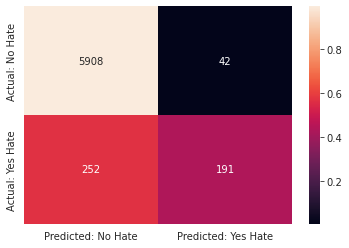

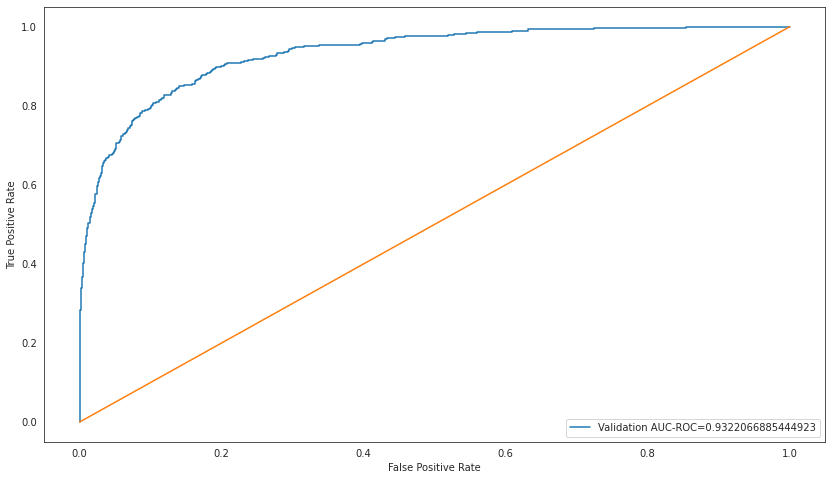

In [16]:
pred, y_pred = train(MultinomialNB(alpha=0.1), MinMaxScaler(), X_train, y_train, X_test)
print(f"ROC AUC Naive Bayes Score: {roc_auc_score(y_test, pred):.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

The orange line seen here represents the random selection. What it says is that if i get 50% of the False Positives in my random selection, I also get 50% of the True Positives or True Users that will hate.

## Logistic Regression & Parameter tuning

In [20]:
for c in [0.0001, 0.001, 0.01, 0.1, 1]:
    pred, y_pred = train(LogisticRegression(solver='liblinear', C=c), StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{c}->{auc:.4f}")

0.0001->0.9308
0.001->0.9250
0.01->0.9230
0.1->0.9173
1->0.9115
10->0.9063


In [21]:
for m in [0.0001, 0.01, 0.001]:
    print(f"Inverse of regularization strength {m}")
    
    for tol in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]:
        pred, y_pred = train(LogisticRegression(solver='liblinear', C=m, tol=tol), StandardScaler(),
                             X_train, y_train, X_test)
        auc = roc_auc_score(y_test, pred)
        print(f"{tol}->{auc:.4f}")
    print()

Inverse of regularization strength 0.0001
1e-05->0.9308
0.0001->0.9308
0.001->0.9308
0.01->0.9308
0.1->0.9308
1->0.9308
10->0.9318

Inverse of regularization strength 0.01
1e-05->0.9230
0.0001->0.9230
0.001->0.9230
0.01->0.9230
0.1->0.9225
1->0.9214
10->0.9172

Inverse of regularization strength 0.001
1e-05->0.9250
0.0001->0.9250
0.001->0.9250
0.01->0.9250
0.1->0.9250
1->0.9242
10->0.9203



In [22]:
for mClass in ["auto", "ovr"]:
    pred, y_pred = train(LogisticRegression(solver='liblinear', C=0.0001, tol=1e-05, multi_class=mClass),
                         StandardScaler(),
                         X_train, y_train, X_test)
    
    auc = roc_auc_score(y_test, pred)
    print(f"{mClass}->{auc:.4f}")

auto->0.9308
ovr->0.9308


ROC AUC Logistic Regression Score: 0.9308


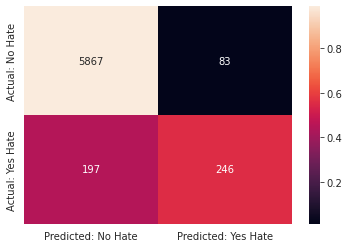

In [23]:
pred, y_pred = train(LogisticRegression(solver='liblinear', C=0.0001, tol=1e-05, multi_class='auto'),
                     StandardScaler(),
                     X_train, y_train, X_test)
print(f"ROC AUC Logistic Regression Score: {roc_auc_score(y_test, pred):.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

#### Apply Cost-Sensitive Logistic Regression for Imbalanced Classification

ROC AUC Logistic Regression Score: 0.9308


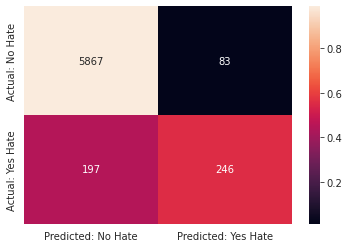

ROC AUC Logistic Regression Score: 0.9335


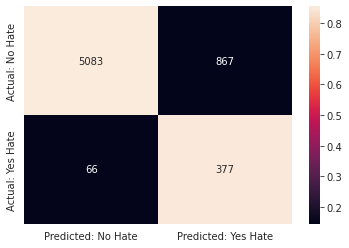

ROC AUC Logistic Regression Score: 0.9329


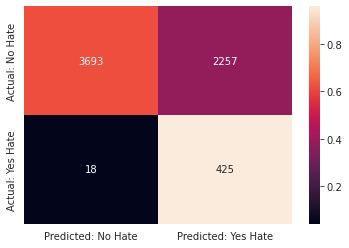

In [24]:
balance = [{0:1,1:1}, {0:1,1:10}, {0:1,1:100}]

for weight in balance:
    pred, y_pred = train(LogisticRegression(solver='liblinear', C=0.0001, tol=1e-05, multi_class='auto',
                                            class_weight=weight),
                         StandardScaler(),
                         X_train, y_train, X_test)
    print(f"ROC AUC Logistic Regression Score: {roc_auc_score(y_test, pred):.4f}")
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrix_plot(cm)
    plt.show()

ROC AUC Logistic Regression Score: 0.9335


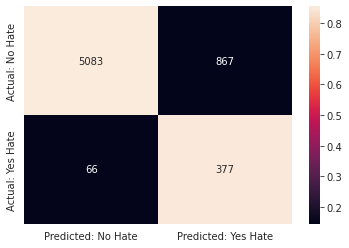

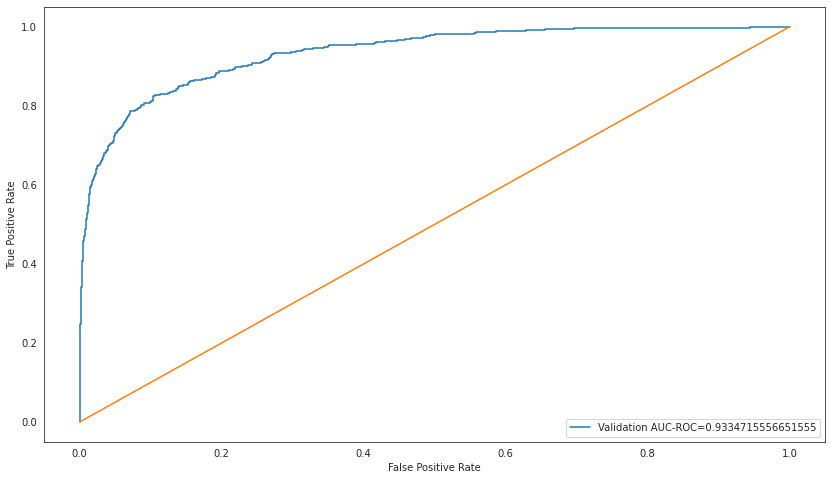

,label,Predicted_class
29830,0,0
21220,0,0
9244,0,0
31397,0,1
6858,0,0
31093,0,0
5549,0,0
24302,0,1
2763,0,0
24455,1,0


In [25]:
pred, y_pred = train(LogisticRegression(solver='liblinear', C=0.0001, tol=1e-05, multi_class='auto',
                                        class_weight={0:1,1:10}),
                     StandardScaler(),
                     X_train, y_train, X_test)
print(f"ROC AUC Logistic Regression Score: {roc_auc_score(y_test, pred):.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test[0:30])
out['Predicted_class'] = y_pred[0:30]
out

## Random Forest & Parameter tuning

In [27]:
for n in [200, 250, 300]:
    pred, y_pred = train(RandomForestClassifier(n_estimators=n, random_state=42),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{n}->{auc:.4f}")

200->0.9308
250->0.9313
300->0.9326


In [28]:
for m in [250, 300]:
    print(f"Number of estimators {m}")
    
    for c in ["gini", "entropy"]:
        pred, y_pred = train(RandomForestClassifier(n_estimators=m, criterion=c, random_state=42),
                             StandardScaler(),
                             X_train, y_train, X_test)
        auc = roc_auc_score(y_test, pred)
        print(f"{c}->{auc:.4f}")
    print()

Number of estimators 250
gini->0.9313
entropy->0.9357

Number of estimators 300
gini->0.9326
entropy->0.9365



In [30]:
for samp in [2]:
    pred, y_pred = train(RandomForestClassifier(n_estimators=300, criterion='entropy', 
                                                max_depth=None, min_samples_split=samp),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{samp}->{auc:.4f}")

2->0.9371


ROC AUC Random Forest Classifier Score: 0.9351
'%' of Misclassified class: 4.458000938526514


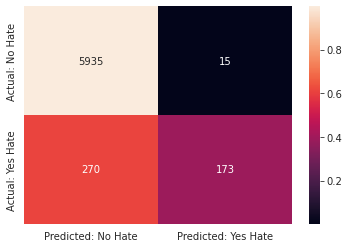

,label,Predicted_class
29830,0,0
21220,0,0
9244,0,0
31397,0,0
6858,0,0
31093,0,0
5549,0,0
24302,0,0
2763,0,0
24455,1,0


In [32]:
pred, y_pred = train(RandomForestClassifier(n_estimators=300, criterion='entropy', min_samples_split=2,
                                            max_depth=None, class_weight={0:1,1:100}, random_state=42),
                     StandardScaler(),
                     X_train, y_train, X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC Random Forest Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test[0:30])
out['Predicted_class'] = y_pred[0:30]
out

ROC AUC Random Forest Classifier Score: 0.9365
'%' of Misclassified class: 4.2233693101830125


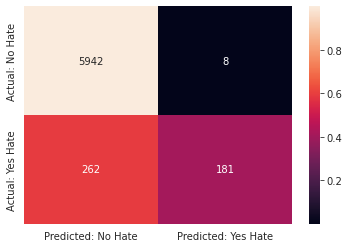

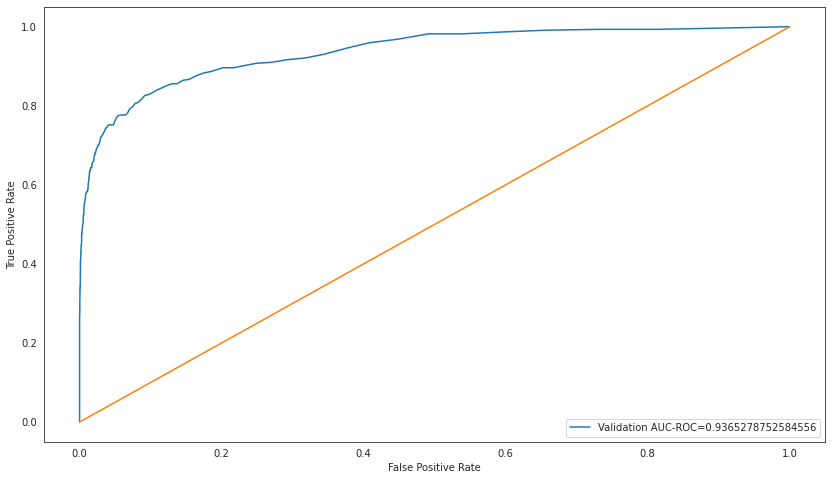

,label,Predicted_class
29830,0,0
21220,0,0
9244,0,0
31397,0,0
6858,0,0
31093,0,0
5549,0,0
24302,0,0
2763,0,0
24455,1,0


In [33]:
pred, y_pred = train(RandomForestClassifier(n_estimators=300, criterion='entropy', min_samples_split=2,
                                            max_depth=None, random_state=42),
                     StandardScaler(),
                     X_train, y_train, X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC Random Forest Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test[0:30])
out['Predicted_class'] = y_pred[0:30]
out

## LGMClassifier & Parameter tuning

In [34]:
for n in [25, 50, 100, 150, 200, 250, 300, 350, 400]:
    pred, y_pred = train(LGBMClassifier(n_estimators=n, objective='binary'),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{n}->{auc:.4f}")

25->0.8989
50->0.9142
100->0.9251
150->0.9283
200->0.9310
250->0.9320
300->0.9335
350->0.9331
400->0.9322


In [35]:
for lr in [0.001, 0.01, 0.1, 1, 1.5, 2, 2.5]:
    pred, y_pred = train(LGBMClassifier(n_estimators=300, objective='binary', learning_rate=lr),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{lr}->{auc:.4f}")

0.001->0.8332
0.01->0.9058
0.1->0.9335
1->0.5061
1.5->0.5054
2->0.5018
2.5->0.5156


ROC AUC LGBM Classifier Score: 0.9335


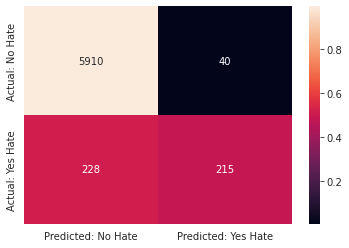

In [36]:
pred, y_pred = train(LGBMClassifier(n_estimators=300, learning_rate=0.1, objective='binary'),
                     StandardScaler(),
                     X_train, y_train, X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC LGBM Classifier Score: {auc:.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

ROC AUC LGBM Classifier Score: 0.9335


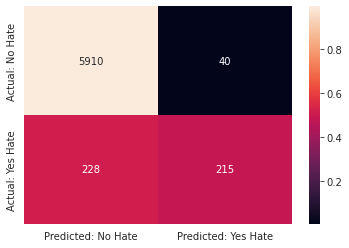

ROC AUC LGBM Classifier Score: 0.9306


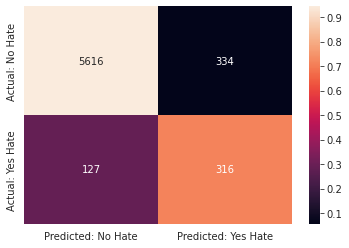

ROC AUC LGBM Classifier Score: 0.9262


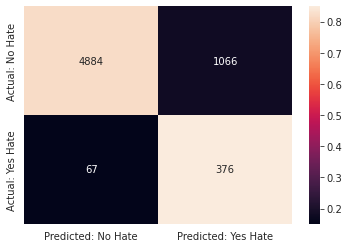

In [37]:
balance = [{0:1,1:1}, {0:1,1:10}, {0:1,1:100}]

for weight in balance:
    pred, y_pred = train(LGBMClassifier(n_estimators=300, learning_rate=0.1, objective='binary',
                                        class_weight=weight),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"ROC AUC LGBM Classifier Score: {auc:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrix_plot(cm)
    plt.show()

ROC AUC LGBM Classifier Score: 0.9306


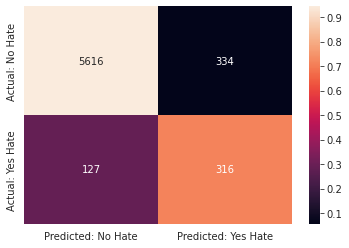

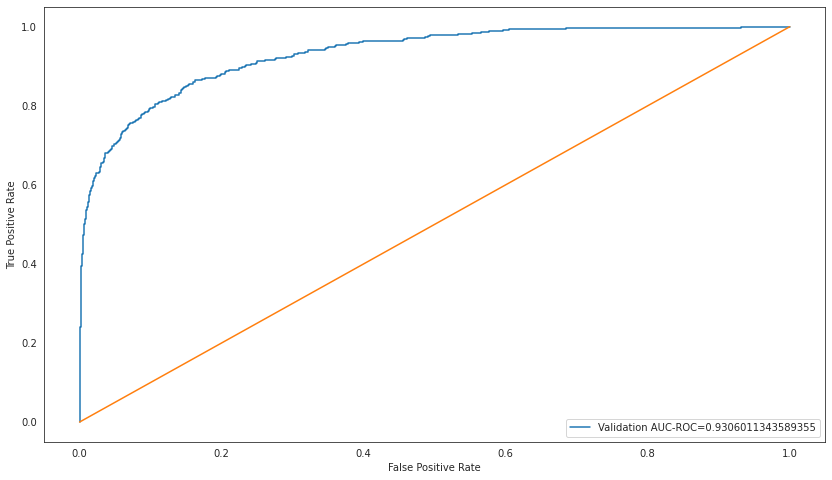

In [38]:
pred, y_pred = train(LGBMClassifier(n_estimators=300, learning_rate=0.1, objective='binary',
                                    class_weight={0:1,1:10}),
                     StandardScaler(),
                     X_train, y_train, X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC LGBM Classifier Score: {auc:.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

## XGBoost & Parameter tuning

In [39]:
for n in [200, 300, 350]:
    pred, y_pred = train(XGBClassifier(n_estimators=n, eval_metric="auc", 
                                       objective='binary:logistic'),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{n}->{auc:.4f}")

200->0.9225
300->0.9233
350->0.9244


In [40]:
for lr in [0.0001, 0.001, 0.1, 1]:
    pred, y_pred = train(XGBClassifier(n_estimators=350, eval_metric="auc", 
                                       objective='binary:logistic', learning_rate=lr),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{lr}->{auc:.4f}")

0.1->0.9196
1->0.9002
1.5->0.8399


ROC AUC XGBoost Classifier Score: 0.9244


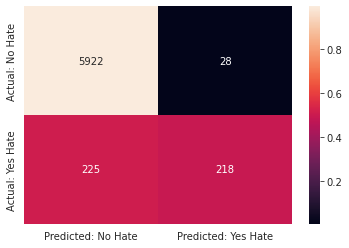

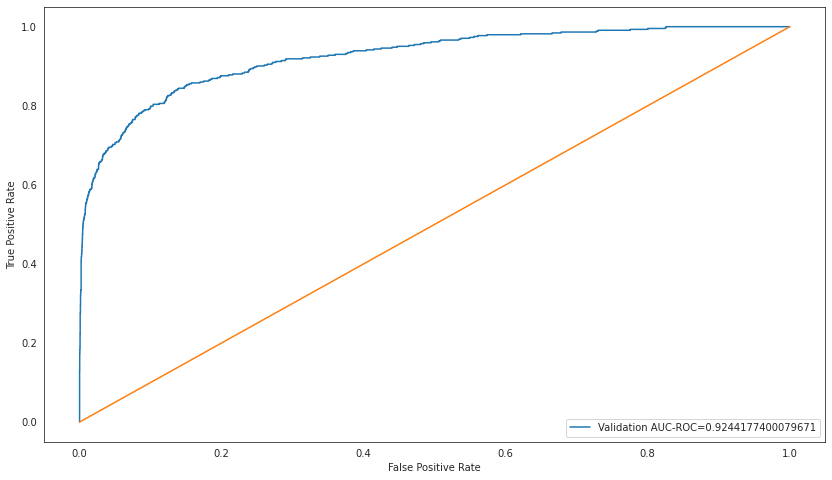

In [41]:
pred, y_pred = train(XGBClassifier(n_estimators=350, eval_metric="auc", 
                                    objective='binary:logistic'),
                     StandardScaler(),
                     X_train, y_train, X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC XGBoost Classifier Score: {auc:.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

The Random Forest model has the best performance. We will use cross validation to prevent overfitting and check so we know the actual scores of individual model.

# Model Evaluation with Cross Validation

In [43]:
def cross_validation_score(ml_model, scaler, thres = 0.5, random_st=42, cols = data_cleaned.columns):
    
    """
    Function to calculate the k fold cross validation stratified on the basis of target
    and prints the ROC, Recall and Precision Scores.
    
    Args:
        ml_model (numpy array) : ml_model for predictions
        thres (float) : threshold for the probabilities of the model predictions
        random_st (int) : random_st is the random state for Kfold
        cols (string) : cols are the column names
    
    Returns:
        cv_scores (float) : cross validation scores
    """
    
    i= 1
    x1 = data_cleaned.copy()
    x1 = data_cleaned[cols]
    cv_scores = []
    
    sKf = StratifiedKFold(n_splits= 5, shuffle= True, random_state= random_st)
    
    for train_index, test_index in sKf.split(x1, y):
        print(f"\n{i} of KFold {sKf.n_splits}")
        xtrain, xval = x1.iloc[train_index], x1.iloc[test_index]
        ytrain, yval = y.iloc[train_index], y.iloc[test_index]
        
        model = ml_model
        pipeline = make_pipeline(scaler, model)
        pipeline.fit(xtrain, ytrain)
        y_pred = pipeline.predict(xval)
        pred_probs = pipeline.predict_proba(xval)
        pp = []
        
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j > thres:
                pp.append(1)
            else:
                pp.append(0)
        # Calculate scores for each fold
        pred_val = pp
        roc_score = roc_auc_score(yval, pred_probs[:,1])
        recall = recall_score(yval, pred_val)
        precision = precision_score(yval, pred_val)
        msg = ""
        msg += f"ROC AUC Score: {roc_score:.4f}, Recall Score: {recall:.4f}, Precision Score: {precision:.4f}"
        print(f"{msg}")
        cv_scores.append(roc_score)
        i+=1
        
    return cv_scores

## Multinomial NB

In [44]:
y=target_labelled_data
nb_cv_score = cross_validation_score(MultinomialNB(alpha=0.1), MinMaxScaler())


1 of KFold 5
ROC AUC Score: 0.9288, Recall Score: 0.4209, Precision Score: 0.7714

2 of KFold 5
ROC AUC Score: 0.9348, Recall Score: 0.4321, Precision Score: 0.7854

3 of KFold 5
ROC AUC Score: 0.9235, Recall Score: 0.4219, Precision Score: 0.7941

4 of KFold 5
ROC AUC Score: 0.9244, Recall Score: 0.4531, Precision Score: 0.7748

5 of KFold 5
ROC AUC Score: 0.9344, Recall Score: 0.4621, Precision Score: 0.7962


## Logistic Regression

In [45]:
log_cv_score = cross_validation_score(LogisticRegression(solver='liblinear', 
                                       C=0.0001, tol=1e-05, multi_class='auto',
                                       class_weight={0:1,1:10}), StandardScaler())


1 of KFold 5
ROC AUC Score: 0.9219, Recall Score: 0.8241, Precision Score: 0.3063

2 of KFold 5
ROC AUC Score: 0.9328, Recall Score: 0.8218, Precision Score: 0.3203

3 of KFold 5
ROC AUC Score: 0.9252, Recall Score: 0.8170, Precision Score: 0.2902

4 of KFold 5
ROC AUC Score: 0.9248, Recall Score: 0.8214, Precision Score: 0.3082

5 of KFold 5
ROC AUC Score: 0.9374, Recall Score: 0.8549, Precision Score: 0.3066


## RandomForestClassifier

In [46]:
rf_cv_score = cross_validation_score(RandomForestClassifier(n_estimators=300,
                                                            criterion='entropy', min_samples_split=2,
                                                            max_depth=None, random_state=42), StandardScaler()
                                    )


1 of KFold 5
ROC AUC Score: 0.9278, Recall Score: 0.3808, Precision Score: 0.9448

2 of KFold 5
ROC AUC Score: 0.9315, Recall Score: 0.3942, Precision Score: 0.9415

3 of KFold 5
ROC AUC Score: 0.9216, Recall Score: 0.4085, Precision Score: 0.9581

4 of KFold 5
ROC AUC Score: 0.9350, Recall Score: 0.4531, Precision Score: 0.9269

5 of KFold 5
ROC AUC Score: 0.9330, Recall Score: 0.4665, Precision Score: 0.9372


## LGBMClassifier

In [47]:
lgm_cv_score = cross_validation_score(LGBMClassifier(n_estimators=300, 
                                    learning_rate=0.1, objective='binary',
                                    class_weight={0:1,1:10}), StandardScaler()
                                    )


1 of KFold 5
ROC AUC Score: 0.9296, Recall Score: 0.6704, Precision Score: 0.4934

2 of KFold 5
ROC AUC Score: 0.9387, Recall Score: 0.6860, Precision Score: 0.5194

3 of KFold 5
ROC AUC Score: 0.9222, Recall Score: 0.6719, Precision Score: 0.5244

4 of KFold 5
ROC AUC Score: 0.9272, Recall Score: 0.7098, Precision Score: 0.4848

5 of KFold 5
ROC AUC Score: 0.9275, Recall Score: 0.6942, Precision Score: 0.5065


## XGBClassifier

In [48]:
xgb_cv_score = cross_validation_score(XGBClassifier(n_estimators=350, 
                                                    eval_metric="auc",
                                                    objective='binary:logistic'), StandardScaler()
                                     )


1 of KFold 5
ROC AUC Score: 0.9340, Recall Score: 0.4766, Precision Score: 0.8425

2 of KFold 5
ROC AUC Score: 0.9376, Recall Score: 0.4410, Precision Score: 0.8148

3 of KFold 5
ROC AUC Score: 0.9209, Recall Score: 0.4866, Precision Score: 0.8516

4 of KFold 5
ROC AUC Score: 0.9303, Recall Score: 0.5112, Precision Score: 0.8358

5 of KFold 5
ROC AUC Score: 0.9315, Recall Score: 0.5201, Precision Score: 0.8034


# Comparison of Model Fold wise

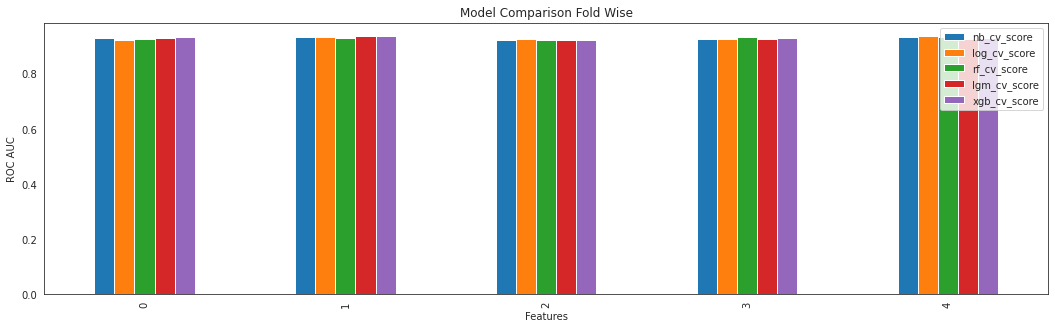

In [49]:
compare_score = pd.DataFrame({'nb_cv_score':nb_cv_score,
                              'log_cv_score':log_cv_score,
                              'rf_cv_score':rf_cv_score,
                              'lgm_cv_score':lgm_cv_score,
                              'xgb_cv_score':xgb_cv_score
                             })

compare_score.plot(y = ['nb_cv_score','log_cv_score','rf_cv_score',
                        'lgm_cv_score','xgb_cv_score'], 
                   kind = 'bar')

plt.title('Model Comparison Fold Wise')
plt.xlabel('Features')
plt.ylabel('ROC AUC');

**The `Logistic Regression Model` & `XGBoost Model` has the best performance across 5-fold. Therefore, we will work on improving them and select the one that generalizes best on unseen data**

In [51]:
xgb_model = XGBClassifier(n_estimators=350, eval_metric="auc", objective='binary:logistic')
xgb_model.fit(X_train, y_train)

step_factor = 0.05
threshold_value = 0.1
roc_score = 0
proba = xgb_model.predict_proba(X_test)

# Continue to check for optimal value when threshold is
# less than 0.8
while threshold_value <= 0.8:
    temp_thresh = threshold_value
    predicted = (proba[:,1] >= temp_thresh).astype('int')
    print(f"Threshold: {temp_thresh}->{roc_auc_score(y_test, predicted)}")
    #store the threshold for best classification
    if roc_score < roc_auc_score(y_test, predicted):
        roc_score = roc_auc_score(y_test, predicted)
        threshold_score = threshold_value
    threshold_value = threshold_value + step_factor
print(f'\n---Optimum Threshold: {threshold_score}->ROC: {roc_score}')

Threshold: 0.2->0.8072282186012102
Threshold: 0.25->0.7902735360509892
Threshold: 0.3->0.7779537909972115
Threshold: 0.35->0.7716497524517708
Threshold: 0.39999999999999997->0.7562323349204242
Threshold: 0.44999999999999996->0.7442371531005179
Threshold: 0.49999999999999994->0.7382214465921809
Threshold: 0.5499999999999999->0.7249295293738263
Threshold: 0.6->0.7172809530132594
Threshold: 0.65->0.7073750403095775
Threshold: 0.7000000000000001->0.6940831230912229
Threshold: 0.7500000000000001->0.6876472485156591

---Optimum Threshold: 0.2->ROC: 0.8072282186012102


In [52]:
cross_validation_score(XGBClassifier(n_estimators=350, eval_metric="auc", 
                                    objective='binary:logistic'),
                                      thres=0.1)


1 of KFold 5
ROC AUC Score: 0.9305, Recall Score: 0.6192, Precision Score: 0.6465

2 of KFold 5
ROC AUC Score: 0.9353, Recall Score: 0.5969, Precision Score: 0.6634

3 of KFold 5
ROC AUC Score: 0.9207, Recall Score: 0.6116, Precision Score: 0.6402

4 of KFold 5
ROC AUC Score: 0.9310, Recall Score: 0.6138, Precision Score: 0.6366

5 of KFold 5
ROC AUC Score: 0.9304, Recall Score: 0.6540, Precision Score: 0.6328


[0.9304724571127105,
 0.9353372755967351,
 0.9206684261440107,
 0.9309798821741011,
 0.9304154624711595]

In [53]:
log_reg = LogisticRegression(solver='liblinear',
                             C=1, tol=1e-05, multi_class='auto',
                             class_weight={0:1,1:100})

log_reg.fit(X_train, y_train)

step_factor = 0.05
threshold_value = 0.1
roc_score = 0
proba = log_reg.predict_proba(X_test)

# Continue to check for optimal value when threshold is
# less than 0.8
while threshold_value <= 0.8:
    temp_thresh = threshold_value
    predicted = (proba[:,1] >= temp_thresh).astype('int')
    print(f"Threshold: {temp_thresh}->{roc_auc_score(y_test, predicted)}")
    #store the threshold for best classification
    if roc_score < roc_auc_score(y_test, predicted):
        roc_score = roc_auc_score(y_test, predicted)
        threshold_score = threshold_value
    threshold_value = threshold_value + step_factor
print(f'\n---Optimum Threshold: {threshold_score}->ROC: {roc_score}')

Threshold: 0.1->0.7197217216457689
Threshold: 0.15000000000000002->0.7462401122977409
Threshold: 0.2->0.7692290911850068
Threshold: 0.25->0.7870079860386594
Threshold: 0.3->0.8010169395071799
Threshold: 0.35->0.8124092797389836
Threshold: 0.39999999999999997->0.8193709808980025
Threshold: 0.44999999999999996->0.8302113170324562
Threshold: 0.49999999999999994->0.8359125139897946
Threshold: 0.5499999999999999->0.8389362065367908
Threshold: 0.6->0.8456820380522412
Threshold: 0.65->0.8530161048618093
Threshold: 0.7000000000000001->0.8557514653717017
Threshold: 0.7500000000000001->0.8571422880664681

---Optimum Threshold: 0.7500000000000001->ROC: 0.8571422880664681


In [54]:
cross_validation_score(LogisticRegression(solver='liblinear', 
                                          C=1, tol=1e-05, multi_class='auto',
                                          class_weight={0:1,1:100}),
                                        thres=0.75)


1 of KFold 5
ROC AUC Score: 0.9224, Recall Score: 0.7884, Precision Score: 0.3324

2 of KFold 5
ROC AUC Score: 0.9380, Recall Score: 0.8597, Precision Score: 0.3190

3 of KFold 5
ROC AUC Score: 0.9239, Recall Score: 0.8304, Precision Score: 0.3012

4 of KFold 5
ROC AUC Score: 0.9258, Recall Score: 0.8460, Precision Score: 0.3037

5 of KFold 5
ROC AUC Score: 0.9408, Recall Score: 0.8795, Precision Score: 0.3112


[0.9223903425287838,
 0.9379584361239423,
 0.923896471231494,
 0.9257917648048453,
 0.9407986444914439]

There is no improvement in the recall score

**Ways to improve this model**
1. Add more training data
2. Try Over/Undersampling techniques like SMOTE

# Addressing Imbalanced Class with SMOTE

In [15]:
print(data_cleaned.shape)
print(target_labelled_data.shape)

(31962, 1018)
(31962,)


In [16]:
print(target_labelled_data.value_counts())
print(target_labelled_data.value_counts(normalize=True)*100)

0    29720
1     2242
Name: label, dtype: int64
0    92.98542
1     7.01458
Name: label, dtype: float64


In [17]:
smote = SMOTE(sampling_strategy='minority')
x_sm, y_sm = smote.fit_resample(data_cleaned, target_labelled_data)
print(y_sm.value_counts())
print(y_sm.value_counts(normalize=True)*100)

0    29720
1    29720
Name: label, dtype: int64
0    50.0
1    50.0
Name: label, dtype: float64


In [18]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(x_sm, y_sm, stratify=y_sm, 
                                                                random_state= 42, test_size= 0.2)

ROC AUC XGBoost Classifier Score: 0.9966
'%' of Misclassified class: 2.2459623149394345


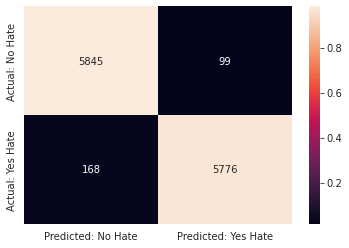

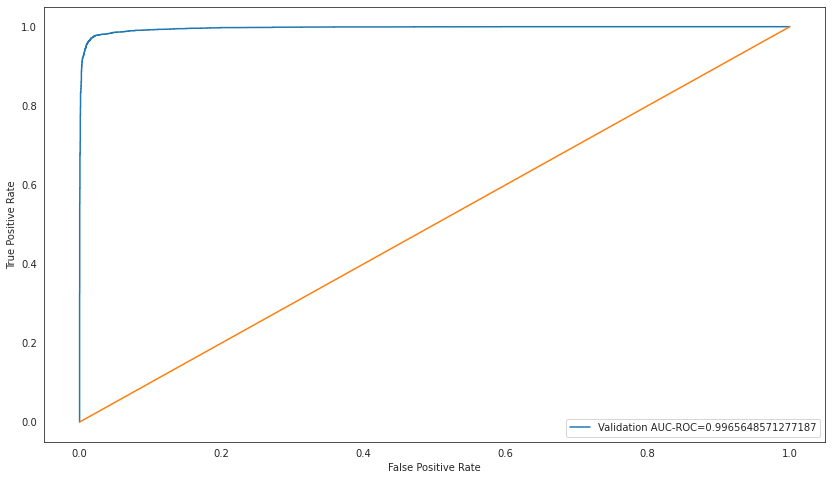

,label,Predicted_class
19659,0,0
16292,0,0
19888,0,0
57178,1,1
44698,1,1
8215,0,0
16936,0,0
28916,0,0
25288,0,0
29736,0,0


In [19]:
pred, y_pred = train(XGBClassifier(n_estimators=350, eval_metric="auc", 
                                    objective='binary:logistic'),
                     StandardScaler(),
                     X_train_sm, y_train_sm, X_test_sm)

auc = roc_auc_score(y_test_sm, pred)
print(f"ROC AUC XGBoost Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test_sm)*100)
cm = confusion_matrix(y_test_sm, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test_sm, pred)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test_sm[0:30])
out['Predicted_class'] = y_pred[0:30]
out

ROC AUC Logistic Regression Classifier Score: 0.9692
'%' of Misclassified class: 14.274899057873485


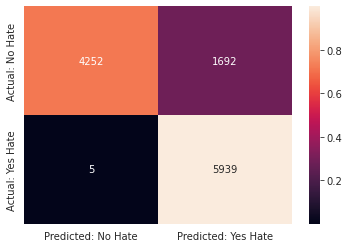

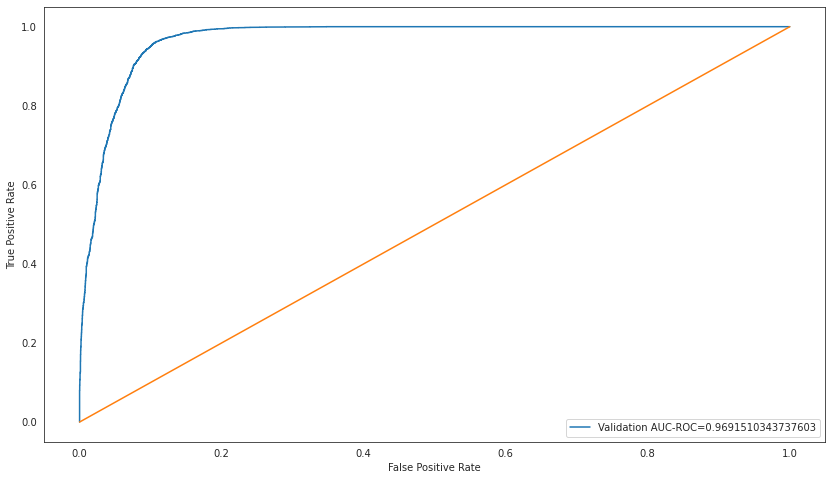

,label,Predicted_class
19659,0,0
16292,0,0
19888,0,1
57178,1,1
44698,1,1
8215,0,0
16936,0,0
28916,0,0
25288,0,0
29736,0,0


In [23]:
pred, y_pred = train(LogisticRegression(solver='liblinear', 
                             C=1, tol=1e-05, multi_class='auto',
                            class_weight={0:1,1:100}),
                     StandardScaler(),
                     X_train_sm, y_train_sm, X_test_sm)

auc = roc_auc_score(y_test_sm, pred)
print(f"ROC AUC Logistic Regression Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test_sm)*100)
cm = confusion_matrix(y_test_sm, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test_sm, pred)
plt.show()

out = pd.DataFrame(y_test_sm[0:30])
out['Predicted_class'] = y_pred[0:30]
out

**We will use the XGBoost Classifier because of it's low '%' of Misclassified labels**

ROC AUC XGBoost Classifier Score: 0.9966
'%' of Misclassified class: 2.2459623149394345


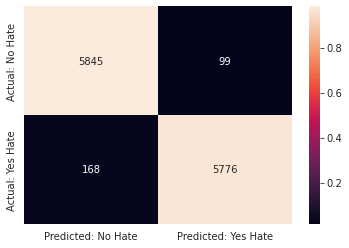

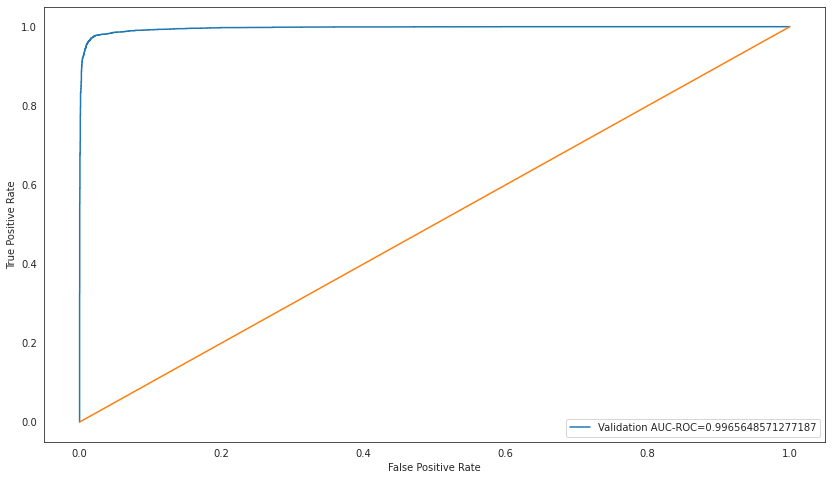

,label,Predicted_class
19659,0,0
16292,0,0
19888,0,0
57178,1,1
44698,1,1
8215,0,0
16936,0,0
28916,0,0
25288,0,0
29736,0,0


In [20]:
xgb_pipeline = make_pipeline(StandardScaler(),
                             XGBClassifier(n_estimators=350, eval_metric="auc", 
                                           objective='binary:logistic'))

xgb_pipeline.fit(X_train_sm, y_train_sm)
pred = xgb_pipeline.predict_proba(X_test_sm)[:, 1]
y_pred = xgb_pipeline.predict(X_test_sm)
auc = roc_auc_score(y_test_sm, pred)
print(f"ROC AUC XGBoost Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test_sm)*100)
cm = confusion_matrix(y_test_sm, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test_sm, pred)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test_sm[0:30])
out['Predicted_class'] = y_pred[0:30]
out

# Pseudo-Labelling based on Confidence

In [21]:
print("Predicting labels for unlabelled data"+".."*2)
preds_probs = xgb_pipeline.predict_proba(unlabelled_cleaned)
preds = xgb_pipeline.predict(unlabelled_cleaned)

prob_0 = preds_probs[:,0]
prob_1 = preds_probs[:,1]
# Store the predictions and probabilities in a dataframe
pseudo_df = pd.DataFrame([])
pseudo_df['pseudo_prediction'] = preds
pseudo_df['prob_0'] = prob_0
pseudo_df['prob_1'] = prob_1
pseudo_df.index = unlabelled_cleaned.index
pseudo_df['max'] = pseudo_df[['prob_0','prob_1']].max(axis=1)

pseudo_df.head()

Predicting labels for unlabelled data....


,pseudo_prediction,prob_0,prob_1,max
0,0,0.980007,0.019993,0.980007
1,0,0.964447,0.035553,0.964447
2,0,0.989853,0.010147,0.989853
3,0,0.987714,0.012286,0.987714
4,0,0.902356,0.097644,0.902356


## Plotting the Confidence

The below graph gives the distribution of confidence as expressed by the probability of the class which is most probable.

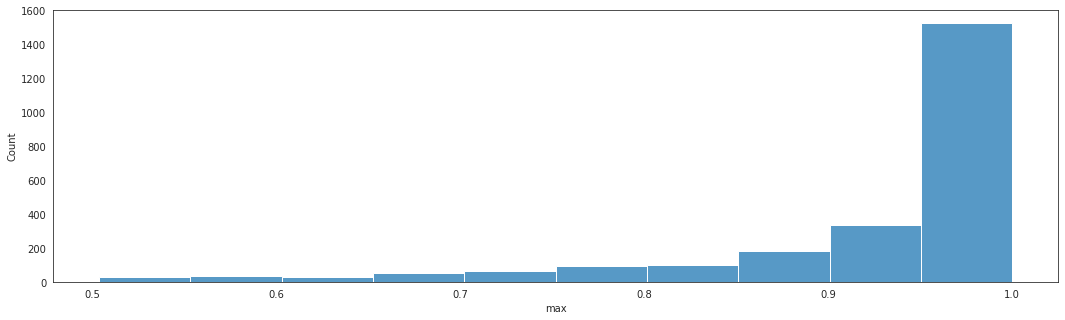

In [22]:
sns.histplot(data = pseudo_df, x = 'max', bins=10)
plt.show()

We will consider probability of 0.8 because of has high probability which means the predicted labels is near accurate.

In [23]:
conf_ind=pseudo_df["max"]>0.8
X_new = np.append(X_train, unlabelled_cleaned.loc[conf_ind,:], axis=0)
y_new = np.append(y_train, pseudo_df.loc[conf_ind, ['pseudo_prediction']])
X_new = pd.DataFrame(X_new, columns = X_train.columns)
y_new = pd.Series(y_new, name = 'label')

print(f"Old Train Data shape: {X_train.shape} \nOld Train label shape: {y_train.shape}\n \nNew Train Data shape: {X_new.shape} \nNew Train label shape: {y_new.shape}\n")

print(X_new.isnull().sum())
print(y_new.isnull().sum())

Old Train Data shape: (25569, 1018) 
Old Train label shape: (25569,)
 
New Train Data shape: (27712, 1018) 
New Train label shape: (27712,)

absolutely            0
accept                0
accounot              0
act                   0
action                0
                     ..
avg_sent_len          0
uniq_vs_words         0
stopwords_vs_words    0
title_word_count      0
uppercase_count       0
Length: 1018, dtype: int64
0


Performance after Semi-Supervised Learning
ROC AUC XGBoost Classifier Score: 0.9195
'%' of Misclassified class: 4.2859377444079465


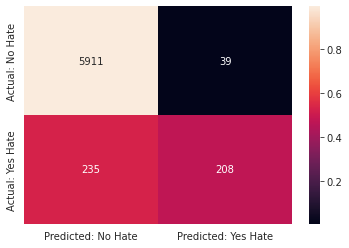

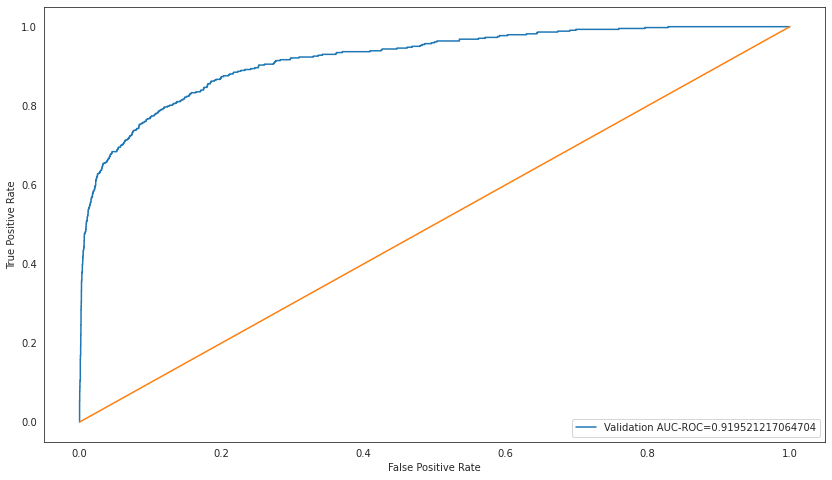

,label,Predicted_class
19659,0,0
16292,0,0
19888,0,0
57178,1,0
44698,1,0
8215,0,0
16936,0,0
28916,0,0
25288,0,0
29736,0,0


In [24]:
xgb_pipeline = make_pipeline(StandardScaler(),
                             XGBClassifier(n_estimators=350, eval_metric="auc", 
                                           objective='binary:logistic'))

xgb_pipeline.fit(X_new, y_new)
pred = xgb_pipeline.predict_proba(X_test)[:, 1]
y_pred = xgb_pipeline.predict(X_test)
auc = roc_auc_score(y_test, pred)
print('Performance after Semi-Supervised Learning')
print(f"ROC AUC XGBoost Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test_sm[0:30])
out['Predicted_class'] = y_pred[0:30]
out

# Apply SMOTE

In [25]:
print(X_new.shape)
print(y_new.shape)

(27712, 1018)
(27712,)


In [26]:
print(y_new.value_counts())
print(y_new.value_counts(normalize=True)*100)

smote = SMOTE(sampling_strategy='minority')
x_sm, y_sm = smote.fit_resample(X_new, y_new)
print()
print('After applying SMOTE')
print(y_sm.value_counts())
print(y_sm.value_counts(normalize=True)*100)

0    25871
1     1841
Name: label, dtype: int64
0    93.356669
1     6.643331
Name: label, dtype: float64

After applying SMOTE
1    25871
0    25871
Name: label, dtype: int64
1    50.0
0    50.0
Name: label, dtype: float64


ROC AUC XGBoost Classifier Score: 0.9967
'%' of Misclassified class: 2.1354720262827325


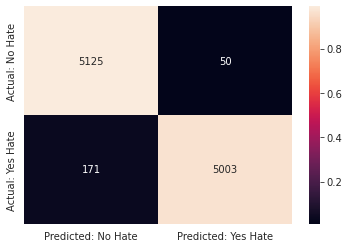

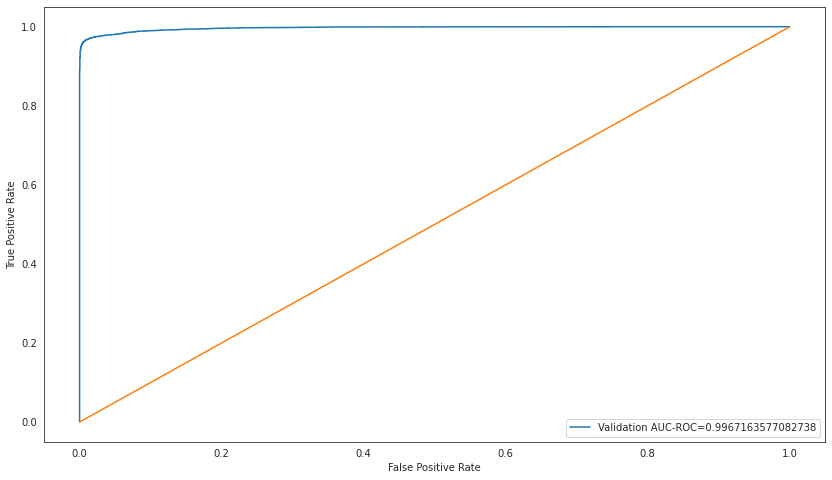

,label,Predicted_class
20802,0,0
44232,1,1
12435,0,0
42926,1,1
47856,1,1
29988,1,1
4001,0,0
45330,1,1
48891,1,1
10191,1,0


In [27]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(x_sm, y_sm, stratify=y_sm, 
                                                                random_state= 42, test_size= 0.2)

pred, y_pred = train(XGBClassifier(n_estimators=350, eval_metric="auc", 
                                    objective='binary:logistic'),
                     StandardScaler(),
                     X_train_sm, y_train_sm, X_test_sm)

auc = roc_auc_score(y_test_sm, pred)
print(f"ROC AUC XGBoost Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test_sm)*100)
cm = confusion_matrix(y_test_sm, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test_sm, pred)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test_sm[0:30])
out['Predicted_class'] = y_pred[0:30]
out

We can see a little improvement in the ROC AUC score and also a reduction in the percentage of Misclassified class. Therefore, we will store this as our final model.

In [ ]:
final_model = make_pipeline(StandardScaler(),
                            XGBClassifier(n_estimators=350, eval_metric="auc", 
                                           objective='binary:logistic'))

final_model.fit(X_train_sm, y_train_sm)
pred = final_model.predict_proba(X_test_sm)[:, 1]
y_pred = final_model.predict(X_test_sm)
auc = roc_auc_score(y_test_sm, pred)
print(f"ROC AUC XGBoost Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test_sm)*100)
cm = confusion_matrix(y_test_sm, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test_sm, pred)
plt.show()

# Serialize Tfidf Vectorizer & the Final Model pipeline

In [ ]:
with open('/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/vectorizers/vectorizerV2.bin', 'wb') as f:
    joblib.dump(tfVectorized, f)
    
with open('/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/models/modelV2.bin', 'wb') as f:
    joblib.dump(final_model, f)